## POSTPROECESSING

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import neptune
from MODULES.vae_model import *
from MODULES.utilities_visualization import show_batch, plot_tiling, plot_label_contours
from MODULES.utilities_visualization import plot_segmentation, movie_from_resolution_sweep
from MODULES.graph_clustering import GraphSegmentation
from MODULES.utilities import QC_on_integer_mask, concordance_integer_masks, load_json_as_dict, load_obj
from MODULES.utilities_visualization import contours_from_labels, add_red_contours
import skimage.io
import skimage.morphology
from IPython.display import HTML
from matplotlib import animation

# Check versions
import torch
import numpy
from platform import python_version
print("python_version() ---> ", python_version())
print("torch.__version__ --> ", torch.__version__)

# make sure to fix the randomness at the very beginning
torch.manual_seed(0)
numpy.random.seed(0)

### Import the files

In [ ]:
params = load_json_as_dict("./ML_parameters.json")
preprocessed = load_obj("streamlined_8_smFISH_stitched_OLEH.tif")
ckpt = file2ckpt(path="./last_ckpt.pt", device=None)
tiling = load_obj("./tiling.pt")

img_torch = preprocessed.img.float()
roi_mask_torch = preprocessed.roi_mask.bool()

vae = CompositionalVae(params)
load_from_ckpt(ckpt=ckpt,
               model=vae,
               optimizer=None,
               overwrite_member_var=False)

### Image to segment

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12,12))
ax[0].imshow(img_torch[0, 0], cmap='gray')
ax[1].imshow(roi_mask_torch[0, 0])

### Compute the tiling

In [ ]:
#with torch.no_grad():
#    start_time = time.time()
#    tiling: Segmentation = vae.segment_with_tiling(single_img=img_torch[0],
#                                                   roi_mask=roi_mask_torch[0],
#                                                   crop_size=None,
#                                                   stride=(20, 20),
#                                                   n_objects_max_per_patch=None,
#                                                   prob_corr_factor=None,
#                                                   overlap_threshold=None,
#                                                   radius_nn=10,
#                                                   batch_size=128)
#    print("tiling time",time.time()-start_time)
#save_obj(tiling, "tiling_large.pt")
tiling = load_obj("tiling_large.pt")

In [ ]:
tiling_fig_large = plot_tiling(tiling, window=None, neptune_name=None)
tiling_fig_large

In [ ]:
ix, iy, size = 940, 2140, 300
window = [ix, iy, ix+size, iy+size]
tiling_fig_small = plot_tiling(tiling, window=window, neptune_name=None)
tiling_fig_small

### Create graph

In [ ]:
g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=True)
print(g.graph["total_nodes"])
print(g.graph["total_edge_weight"])
g.graph.summary()

### Plot segmentation before graph approach

In [ ]:
plot_label_contours(label=tiling.integer_mask[0,0],
                    image=tiling.raw_image[0],
                    window=window,
                    contour_thickness=2,
                    neptune_name=None) #"tiling_contours_graph")

### Perform sweep on a small window

In [ ]:
# sweep = numpy.arange(1.0, 20.0)
sweep = numpy.linspace(start=1, stop=800, num=20)
print(sweep)
suggestion_mod_true = g.suggest_resolution_parameter(min_size=20,
                                                     window=window,
                                                     cpm_or_modularity="modularity",
                                                     each_cc_separately=False,
                                                     sweep_range=sweep)

### See the sweep

In [ ]:
suggestion_mod_true.show_graph(figsize=(8,8))


In [ ]:
suggestion_mod_true.show_best(figsize=(8,8))

In [ ]:
movie_from_resolution_sweep(suggestion_mod_true, tiling.raw_image[0,0,window[0]:window[2],window[1]:window[3]])

### Do community detection with the chiosen resolution parameter

In [ ]:
import time
start_time = time.time()
resolution = 400.0

partition = g.find_partition_leiden(resolution=resolution, 
                                    min_size=20, 
                                    cpm_or_modularity="modularity", 
                                    each_cc_separately=False,
                                    n_iterations=10,
                                    initial_membership=None) 
print("community detection time",time.time()-start_time)

### Vefiry results on the small window and check consistency

In [ ]:
graph_integer_mask = g.partition_2_integer_mask(partition)
save_obj(graph_integer_mask, "graph_integer_mask_large.pt")
skimage.io.imsave("luca_small.tif", graph_integer_mask.cpu().numpy(), plugin=None, check_contrast=True)

In [ ]:
plot_label_contours(label=graph_integer_mask,
                    image=tiling.raw_image[0, 0],
                    window=window,
                    contour_thickness=2,
                    neptune_name=None)

In [ ]:
plot_label_contours(label=g.example_integer_mask,
                    image=tiling.raw_image[0, 0],
                    window=window,
                    contour_thickness=2,
                    neptune_name=None)

# Load results by Oleh for comparison

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import skimage.io
import skimage.transform
import skimage.morphology
import skimage.exposure
import numpy
from typing import Optional
from MODULES.utilities_visualization import add_red_contours, contours_from_labels

In [39]:
oleh_file = "oleh_big.tif"
luca_file = "luca_small.tif"
manual_file = "manual_annotation_big.tif"
raw_image_file = "smFISH_stitched_OLEH.tif"
luca_file_old = "segmentation_res800.tiff"

In [4]:
raw_img = skimage.img_as_ubyte(skimage.exposure.rescale_intensity(skimage.io.imread(raw_image_file)))
oleh_label = skimage.io.imread(oleh_file).astype(numpy.uint16)
gt_label = skimage.io.imread(manual_file).astype(numpy.uint16)
luca_label_small = skimage.io.imread(luca_file).astype(numpy.uint16)
luca_label_old_small = skimage.io.imread(luca_file_old).astype(numpy.uint16)


In [44]:
luca_label = skimage.transform.resize(luca_label_small, oleh_label.shape,
                                      order=0, clip=True, preserve_range=True).astype(numpy.uint16)
luca_label_old = skimage.transform.resize(luca_label_old_small, oleh_label.shape,
                                          order=0, clip=True, preserve_range=True).astype(numpy.uint16)

skimage.io.imsave("luca_big.tif", luca_label, plugin=None, check_contrast=True)
skimage.io.imsave("luca_big_old.tif", luca_label_old, plugin=None, check_contrast=True)

In [46]:
c1 = contours_from_labels(luca_label_old, contour_thickness=3)
tmp1 = add_red_contours(raw_img, c1)
skimage.io.imsave("smFISH_contours_full_res.tif", tmp1, plugin=None, check_contrast=True)

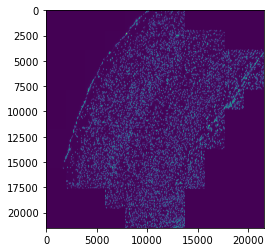

In [8]:
plt.imshow(raw_img)

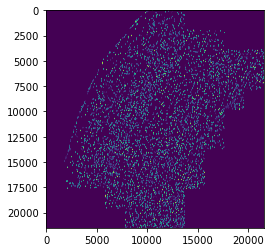

In [9]:
plt.imshow(luca_label)

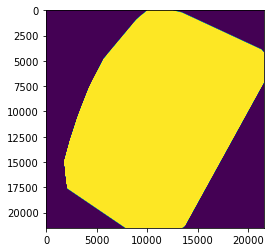

In [10]:
ROI_mask = skimage.morphology.convex_hull_image(luca_label > 0)
plt.imshow(ROI_mask)

In [12]:
print(luca_label.shape)
print(oleh_label.shape)
print(gt_label.shape)
print(raw_img.shape)

(21505, 21505)
(21505, 21505)
(21505, 21505)
(21505, 21505)


### Plot comparisons

In [29]:
def make_list_of_windows(ROI_mask: numpy.ndarray, n: int = 4, crop_size: int = 80):
    window = list()
    while len(window)<n:
        iw = numpy.random.randint(low=0, high=ROI_mask.shape[0]-crop_size, size=1, dtype=int).item()
        ih = numpy.random.randint(low=0, high=ROI_mask.shape[1]-crop_size, size=1, dtype=int).item()
        fraction = float(numpy.sum(ROI_mask[iw:iw+crop_size, ih:ih+crop_size]))/(iw*ih)
        if fraction<0.3 :
            continue
        else:
            window.append((iw,ih,iw+crop_size,ih+crop_size))
    return window

def plot_comparison(raw_img: numpy.ndarray, 
                    labels1: numpy.ndarray, 
                    labels2: Optional[numpy.ndarray] = None, 
                    labels3: Optional[numpy.ndarray] = None,
                    window: Optional[list] = None, 
                    figsize: tuple =(24,24)):
    if window is None:
        window = [[0,0,img1.shape[0],img1.shape[1]]]
    
    n = len(window)
    if n>1:
        fig, axs = plt.subplots(nrows=n, ncols=3, figsize=figsize)
    else:
        fig, axs = plt.subplots(ncols=3, figsize=figsize)
        
    for row,w in enumerate(window):
        img = raw_img[w[0]:w[2],w[1]:w[3]]
        l1 = labels1[w[0]:w[2],w[1]:w[3]]
        l2 = labels2[w[0]:w[2],w[1]:w[3]]
        l3 = labels3[w[0]:w[2],w[1]:w[3]]
        c1 = contours_from_labels(l1, contour_thickness=3)
        c2 = contours_from_labels(l2, contour_thickness=3)
        c3 = contours_from_labels(l3, contour_thickness=3)
        tmp1 = add_red_contours(img, c1)
        tmp2 = add_red_contours(img, c2)
        tmp3 = add_red_contours(img, c3)
        # print(tmp1.dtype, img.dtype)

        if n>1:
            axs[row,0].imshow(tmp1, aspect='equal')
            axs[row,1].imshow(tmp2, aspect='equal')
            axs[row,2].imshow(tmp3, aspect='equal')
        else:
            axs[0].imshow(tmp1, aspect='equal')
            axs[1].imshow(tmp2, aspect='equal')
            axs[2].imshow(tmp3, aspect='equal')

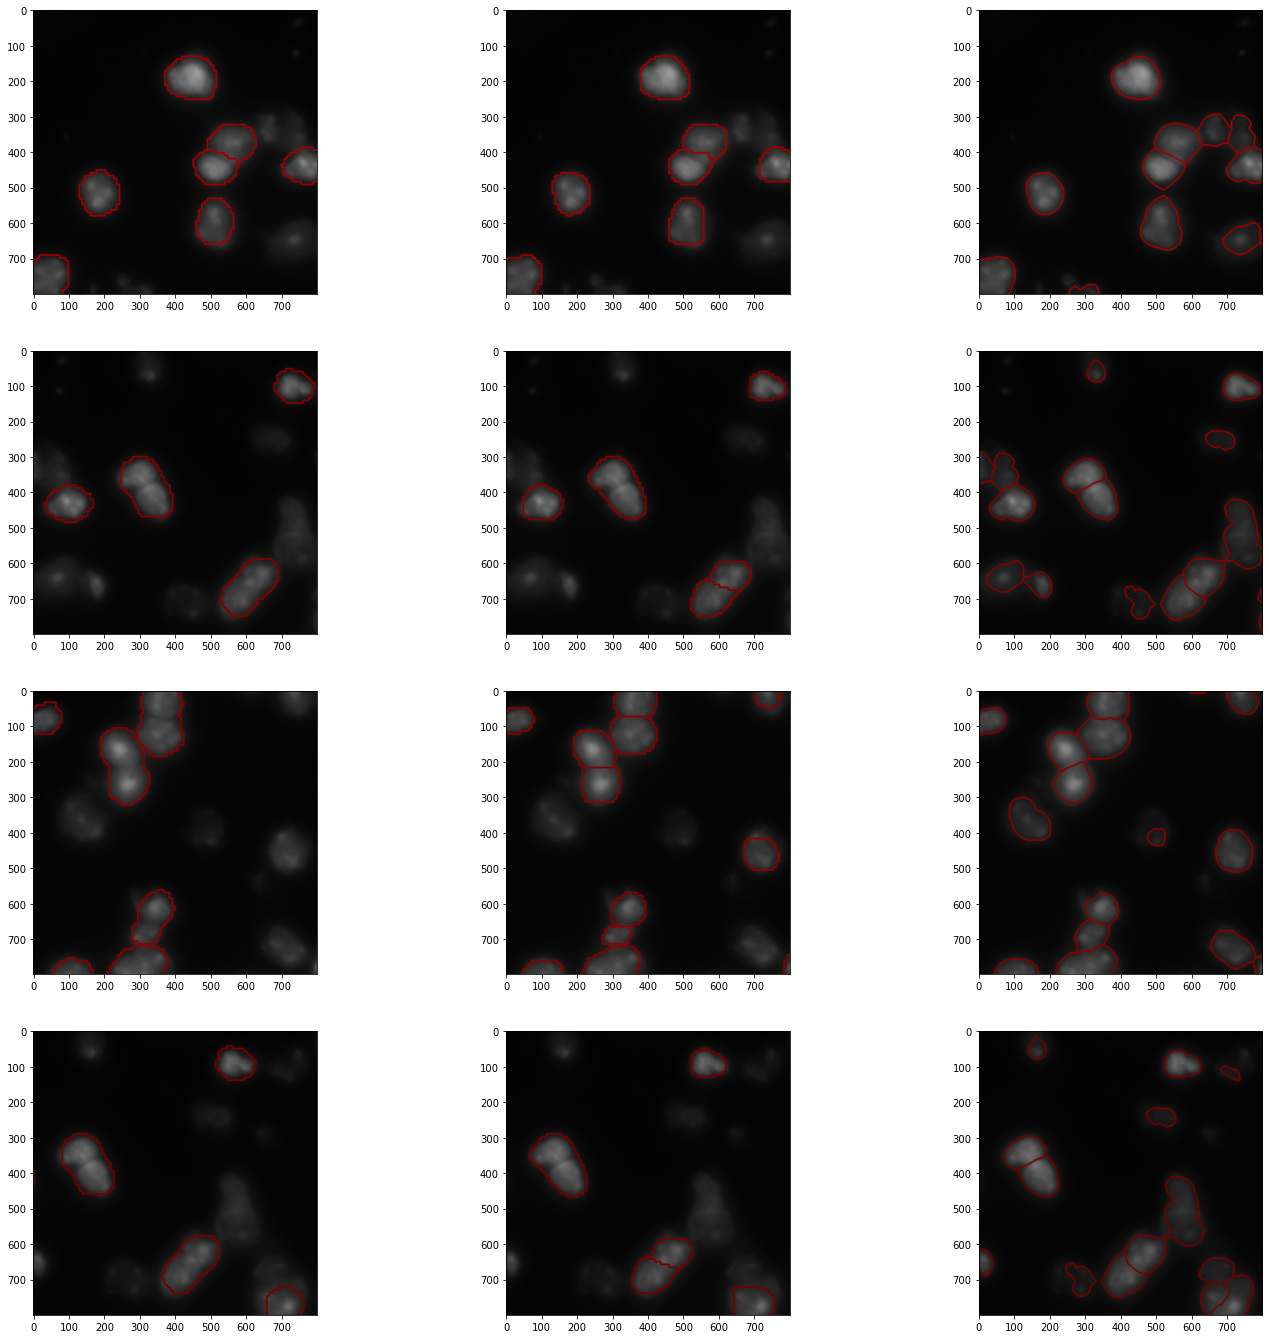

In [45]:
window = make_list_of_windows(ROI_mask, n=4, crop_size=800)
plot_comparison(raw_img, luca_label, luca_label_old, oleh_label, window=window, figsize=(24,24))